<a href="https://colab.research.google.com/github/Plumz17/PCD_FinalProject/blob/main/PCD_FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Digital Image Processing Final Project - Group 5
* Anders Emmanuel Tan (24/541351/PA/22964) KOMB
* Evan Razzan Adytaputra (24/545257/PA/23166) KOMB
* Indratanaya Budiman (24/534784/PA/22683) KOMA
* Daffa Maulana Siddiq (24/533358/PA/22569) KOMA


## 1. Setting Up Image to be Processed (Image Acquisition)


In [ ]:
#Cloning Github Repository to get the Image
!rm -rf PCD_FinalProject
!git clone https://github.com/Plumz17/PCD_FinalProject

Cloning into 'PCD_FinalProject'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 23 (delta 8), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (23/23), 547.33 KiB | 21.05 MiB/s, done.
Resolving deltas: 100% (8/8), done.


In [ ]:
# #Upload Kaggle API to Download Dataset
# from google.colab import files
# files.upload()

In [ ]:
# #Download Dataset
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
# !kaggle datasets download -d tawsifurrahman/tuberculosis-tb-chest-xray-dataset
# !unzip tuberculosis-tb-chest-xray-dataset.zip -d TB_Dataset

In [ ]:
# Import Important Libraries
import cv2 # For Reading Image
import numpy as np # For Manipulating Image Matrix
import matplotlib.pyplot as plt # For Showing Image
import math # For Math
import os #Access Folder

filename_normal = "/content/PCD_FinalProject/normal.png"
filename_tbc = "/content/PCD_FinalProject/tbc.png"

img_normal = cv2.imread(filename_normal) # Read Image
img_normal = cv2.cvtColor(img_normal, cv2.COLOR_BGR2GRAY) # Change the color map

img_tbc = cv2.imread(filename_tbc) # Read Image
img_tbc = cv2.cvtColor(img_tbc, cv2.COLOR_BGR2GRAY) # Change the color map


In [ ]:
def show(before, after, title1="TBC", title2="Normal"): # Helper function to check the before and after of the enhancement
  plt.figure(figsize=(10,5))

   # Show original
  plt.subplot(1,2,1)
  plt.imshow(before, cmap='gray', vmin=0, vmax=255) #vmin and max to preserve original image's contrast
  plt.title(title1)
  plt.axis("off")

  # Show processed
  plt.subplot(1,2,2)
  plt.imshow(after, cmap='gray', vmin=0, vmax=255)
  plt.title(title2)
  plt.axis("off")

  plt.show()

## 2. Image Enhancement


###2A. Gaussian Smoothing

###2B. Laplacian Sharpening

###2C. Histogram Equilization

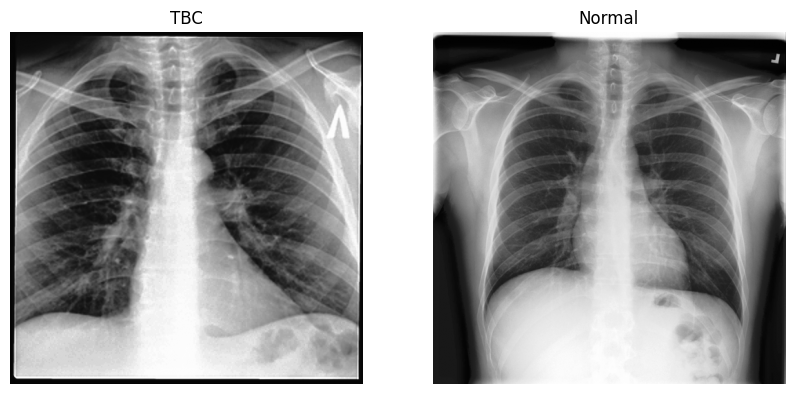

In [ ]:
def hist(img):
  L = 256
  #Make Histograms
  hist = np.zeros(L)
  for i in range(img.shape[0]):#Iterate for every pixel in the x axis (Reminder that img.shape returns (width, height, channel))
    for j in range(img.shape[1]): #Iterate for every pixel in the y axis
      hist[int(img[i,j])] += 1 # Add that pixel to the histogram

  pdf = hist / (img.shape[0] * img.shape[1]) # Calculate the probablity distribution function (From Probability and Stotastic Process Subject)
  cdf = np.zeros(L)
  cdf[0] = pdf[0]
  for i in range(1, L): # Calculate the cumulative distribution function
    cdf[i] = cdf[i - 1] + pdf[i]

  cdf = (cdf * (L - 1)).astype(np.uint8) # Calculate the pixel value using cdf so it's between 0 and 255

  out = np.zeros(img.shape, dtype=np.uint8)
  for i in range(out.shape[0]):#Iterate for every pixel in the x axis (Reminder that img.shape returns (width, height, channel))
    for j in range(out.shape[1]): #Iterate for every pixel in the y axis
      out[i,j] = cdf[img[i,j]]
  return out

img_tbc_hist = hist(img_tbc)
img_normal_hist = hist(img_normal)

show(img_tbc_hist, img_normal_hist)

## 3. Image Segmentation


In [ ]:
def find_otsu_threshold(image):
  hist, bins = np.histogram(image.flatten(), 256, [0, 256]) #Make the PDF of the histogram
  totalPixel = image.size
  normilizedProb = hist / totalPixel # Normalize the histogram for easier calculation
  intensityLevels = np.arange(256)
  #Define used variables to minimize WCI
  minVariance = float("inf")
  optimalTreshold = 0

  #Loop over every single Threshold from 0 to 255
  for T in range(256):
    #Calculate Weight, Mean, and Variance of background
    wb = np.sum(normilizedProb[:T + 1])
    if wb == 0:
      continue
    meanb_up = np.sum(intensityLevels[:T + 1] * normilizedProb[:T + 1])
    meanb = meanb_up / wb
    varianceb_up = np.sum(normilizedProb[:T + 1] * (intensityLevels[:T + 1] - meanb)**2)
    varianceb = varianceb_up / wb

    #Calculate Weight, Mean, and Variance of foreground
    wf = np.sum(normilizedProb[T + 1:])
    if wf == 0:
      break

    meanf_up = np.sum(intensityLevels[T + 1:] * normilizedProb[T + 1:])
    meanf = meanf_up / wf
    variancef_up = np.sum(normilizedProb[T + 1:] * (intensityLevels[T + 1:] - meanf)**2)
    variancef = variancef_up / wf

    #Use Otsu Method Formula
    within_class_variance = wb * varianceb + wf * variancef

    #Override Threshold if more otpimal
    if within_class_variance < minVariance:
      minVariance = within_class_variance
      optimalTreshold = T
  return optimalTreshold

def segment(image):
  threshold = find_otsu_threshold(image)
  print(threshold)
  segmented_image = np.zeros(image.shape, dtype = np.uint8)
  row, col = image.shape

  for r in range(row):
    for c in range(col):
      if image[r,c] < threshold:
        segmented_image[r,c] = 255
      else:
        segmented_image[r,c] = 0

  return segmented_image

img_tbc_hist = segment(img_tbc_hist)
img_normal_hist = segment(img_normal_hist)

130
127


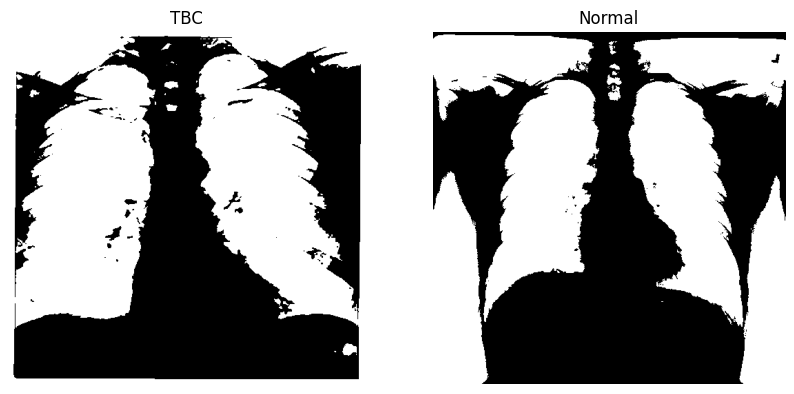

In [ ]:
show(img_tbc_hist, img_normal_hist)

## 4. Morphological Processes

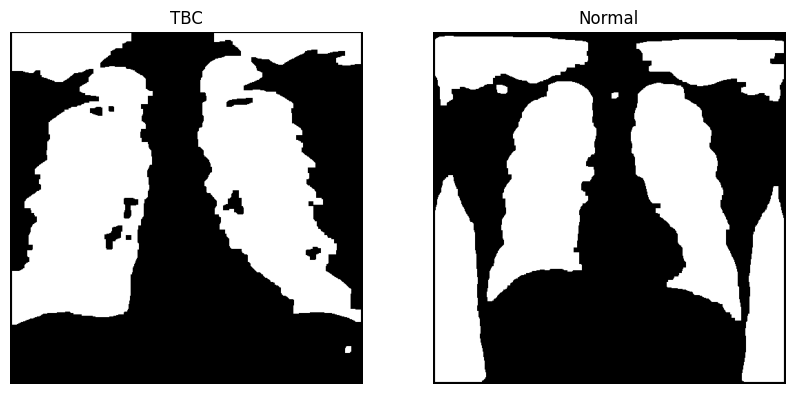

In [ ]:
def dilate(img, kernel_size = 3):
  rows, cols = img.shape
  dilated = np.zeros_like(img)
  kernel = np.ones((kernel_size, kernel_size), dtype=int)
  k_rows, k_cols = kernel.shape
  pad_rows, pad_cols = k_rows // 2, k_cols // 2 #Calculate padding amojnt

  padded = np.pad(img, ((pad_rows, pad_rows), (pad_cols, pad_cols)), mode='constant', constant_values=0) #Pad zero to the edge of the kernel
  for i in range(rows): #Process Every pixel
    for j in range(cols):
      region = padded[i:i+k_rows,j:j+k_cols] #Find Overlapped Region
      if np.any(region * kernel): #If region and kernel overlapped change background to foreground
        dilated[i, j] = 255
      else:
        dilated[i, j] = 0
  return dilated

def erode(img, kernel_size = 3):
  rows, cols = img.shape
  eroded = np.zeros_like(img)
  kernel = np.ones((kernel_size, kernel_size), dtype=int)
  k_rows, k_cols = kernel.shape
  pad_rows, pad_cols = k_rows // 2, k_cols // 2 #Calculate padding amojnt

  padded = np.pad(img, ((pad_rows, pad_rows), (pad_cols, pad_cols)), mode='constant', constant_values=0) #Pad zero to the edge of the kernel
  for i in range(rows): #Process Every pixel
    for j in range(cols):
      region = padded[i:i+k_rows,j:j+k_cols] #Find Overlapped Region
      if np.all(region * kernel == 255): #Change foreground to background if region is not in all of kernel
        eroded[i, j] = 255
      else:
        eroded[i, j] = 0
  return eroded

def closing(img, kernel_size = 3):
  opened = dilate(img, kernel_size)
  eroded = erode(opened, kernel_size)
  return opened

img_tbc_hist = closing(img_tbc_hist, 7)
img_normal_hist = closing(img_normal_hist, 7)

show(img_tbc_hist, img_normal_hist)


In [ ]:
import cv2
import numpy as np

def get_largest_blobs(image, num_blobs=2):
  # Find connected components
  num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(image, connectivity=8)

  # Get the sizes of the blobs (excluding the background)
  blob_sizes = stats[1:, cv2.CC_STAT_AREA]

  # Get the indices of the largest blobs
  largest_blob_indices = np.argsort(blob_sizes)[-num_blobs:] + 1 # Add 1 to account for background

  # Create a list of images containing the largest blobs
  largest_blobs_images = []
  for i in largest_blob_indices:
    # Create a mask for the current blob
    mask = np.zeros_like(image, dtype=np.uint8)
    mask[labels == i] = 255

    # Apply the mask to the original image (or the segmented image)
    # You can choose to apply it to the original grayscale image here if needed for feature extraction later
    # For now, we'll return the masked segmented blob
    largest_blobs_images.append(cv2.bitwise_and(image, image, mask=mask))

  return largest_blobs_images

# Assuming img_tbc_hist and img_normal_hist are your segmented images
largest_tbc_blobs = get_largest_blobs(img_tbc_hist)
largest_normal_blobs = get_largest_blobs(img_normal_hist)

# Now you have a list of images, each containing one of the two largest blobs
# You can visualize them or proceed with feature extraction on these blobs

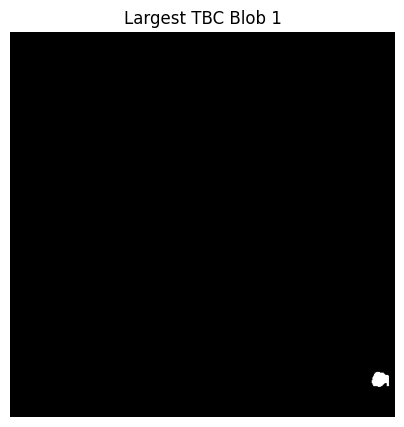

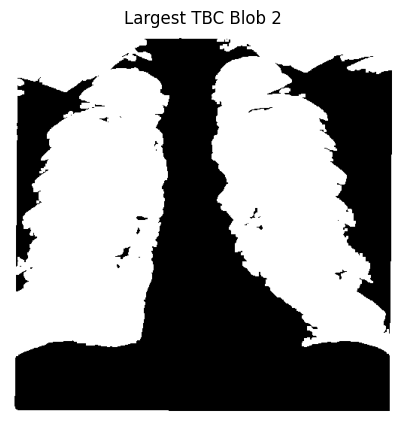

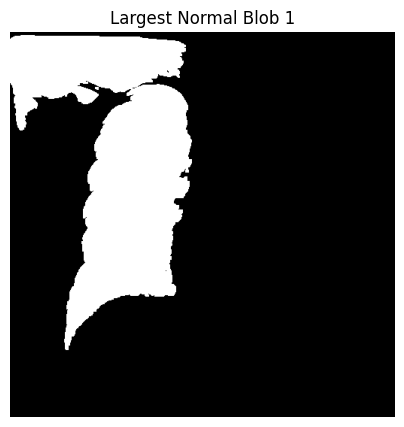

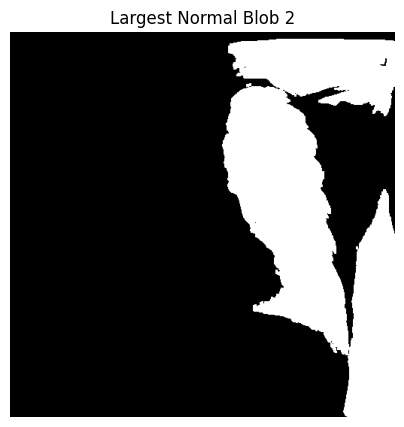

In [ ]:
for i, blob in enumerate(largest_tbc_blobs):
  plt.figure(figsize=(5,5))
  plt.imshow(blob, cmap='gray')
  plt.title(f"Largest TBC Blob {i+1}")
  plt.axis("off")
  plt.show()

for i, blob in enumerate(largest_normal_blobs):
  plt.figure(figsize=(5,5))
  plt.imshow(blob, cmap='gray')
  plt.title(f"Largest Normal Blob {i+1}")
  plt.axis("off")
  plt.show()

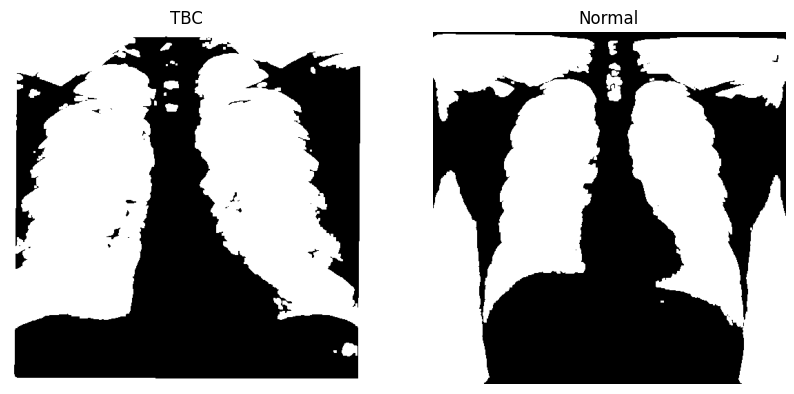

In [ ]:
show(img_tbc_hist, img_normal_hist)


## 5. Feature Extraction

## 6. Representation and Matching

## 7. Train Model

In [ ]:
# Process all images in the dataset

# Define the directories for normal and TB images
normal_dir = "/content/TB_Dataset/TB_Chest_Radiography_Database/Tuberculosis"
tbc_dir = "/content/TB_Dataset/TB_Chest_Radiography_Database/Normal"

images = []
labels = []

# Function to process a single image
def process_image(image_path):
  img = cv2.imread(image_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img_hist = hist(img) # Apply histogram equalization
  img_segmented = segment(img_hist) # Apply Otsu thresholding
  #img_opened = opening(img_segmented, 3) # Apply morphological opening
  return img_segmented

# Process normal images
for filename in os.listdir(normal_dir):
  if filename.endswith(".png"): # Assuming images are in PNG format
    image_path = os.path.join(normal_dir, filename)
    processed_img = process_image(image_path)
    images.append(processed_img)
    labels.append(0) # 0 for normal

# Process TB images
for filename in os.listdir(tbc_dir):
  if filename.endswith(".png"): # Assuming images are in PNG format
    image_path = os.path.join(tbc_dir, filename)
    processed_img = process_image(image_path)
    images.append(processed_img)
    labels.append(1) # 1 for TB

print(f"Processed {len(images)} images.")

FileNotFoundError: [Errno 2] No such file or directory: '/content/TB_Dataset/TB_Chest_Radiography_Database/Tuberculosis'